## Example 1

In [ ]:
import numpy as np
from mip import Model, xsum, maximize, BINARY
np.random.seed(47404)

I = np.random.uniform(0.5,1.5,100)
n = len(I)
c = 10

## Initialize model.
m = Model("assembly")

## Add binary variables.
x = [m.add_var(var_type=BINARY) for i in range(n)]

## Define objective.
m.objective = maximize(xsum(I[i] * x[i] for i in range(n)))

## Define contraint (maximum number of items).
m += xsum(x[i] for i in range(n)) <= c

## Optimize.
m.optimize(max_seconds=120)

optimal = np.sort(np.arange(n)[np.argsort(I)[::-1]][:10])
selected = np.array([i for i in range(n) if x[i].x >= 0.99])
print(optimal)
print(selected)

## Example 2

In [ ]:
import numpy as np
from mip import Model, xsum, maximize, BINARY
np.random.seed(47404)

I1 = np.random.uniform(0.5,1.5,100)
I2 = np.random.uniform(0.5,1.5,100)
I3 = np.random.uniform(0.5,1.5,100)
I = I1 + I2 + I3
n = len(I)
c = 10

## Initialize model.
m = Model("assembly")

## Add binary variables.
x = [m.add_var(var_type=BINARY) for i in range(n)]

## Define objective.
m.objective = maximize(xsum(x[i] * (I1[i] + I2[i] + I3[i]) for i in range(n)))

## Define contraint (maximum number of items).
m += xsum(x[i] for i in range(n)) <= c
m += xsum(x[i] * (I1[i] - I2[i]) for i in range(n)) <= 0.001
m += xsum(x[i] * (I1[i] - I2[i]) for i in range(n)) >= -0.001

## Optimize.
m.optimize(max_seconds=120)

optimal = np.sort(np.arange(n)[np.argsort(I)[::-1]][:10])
selected = np.array([i for i in range(n) if x[i].x >= 0.99])
print(optimal)
print(selected)

## Example 3

In [ ]:
import numpy as np
from mip import Model, xsum, maximize, BINARY
np.random.seed(47404)

I = np.random.uniform(0.5,1.5,50)
n = len(I)
c = 10

## Initialize model.
m = Model("assembly")

## Add binary variables.
x = [m.add_var(var_type=BINARY) for i in range(n)]

## Define objective.
m.objective = maximize(xsum(x[i] * (I1[i] + I2[i] + I3[i]) for i in range(n)))

## Define contraint (maximum number of items).
m += xsum(x[i] for i in range(n)) <= c
for i in range(0,n,2): 
    m += x[i] + x[i+1] <= 1

## Optimize.
m.optimize(max_seconds=120)

optimal = np.sort(np.arange(n)[np.argsort(I)[::-1]][:10])
selected = np.array([i for i in range(n) if x[i].x >= 0.99])
print(optimal)
print(selected)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from scipy.stats import norm
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Extract parameters.
params = read_csv('stan_results/3pl_summary.tsv', sep='\t', index_col=0)
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values

## Extract DIF. 
dif = read_csv('stan_results/dif.csv')
dif = np.repeat(np.where(dif.fwe2 < 0.05, 1, 0), 2)

## Extract IFS.
ifs = read_csv('stan_results/3pl_ifs.csv')
ifs = np.where(ifs.p >= 0.95, 1, 0)

## Define exclusions.
exclude = np.logical_or(dif, ifs).astype(int)

## 
items = np.arange(exclude.size)
items = items[exclude == 0]
beta  = beta[exclude == 0]
alpha = alpha[exclude == 0]
gamma = 0.25

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

theta = np.array([-1,0,1])
template = norm(0,1).pdf(theta)

mu = np.outer(theta, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
q = 1 - p

I = alpha**2 * (q / p) * np.square((p - gamma) / (1 - gamma))
I = I.T

In [ ]:
import numpy as np
from mip import Model, xsum, maximize, BINARY
np.random.seed(47404)

n = len(I)
c = 12

## Initialize model.
m = Model("assembly")

## Add binary variables.
x = [m.add_var(var_type=BINARY) for i in range(n)]

## Define objective.
m.objective = maximize(xsum(x[i] * I[i].sum() for i in range(n)))

## Define contraint (maximum number of items).
m += xsum(x[i] for i in range(n)) <= c
for i in range(0,n,2): 
    m += x[i] + x[i+1] <= 1

## Optimize.
m.optimize(max_seconds=120)

selected = np.array([i for i in range(n) if x[i].x >= 0.99])
print(selected)

In [ ]:
theta = np.linspace(-3,3,1001)
template = norm(0,1).pdf(theta)

mu = np.outer(theta, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
q = 1 - p

I = alpha**2 * (q / p) * np.square((p - gamma) / (1 - gamma))
I = I.T

In [ ]:
plt.plot(theta, I[selected].sum(axis=0))

## Intuition building

can we recreate the prob?

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mip import Model, xsum, maximize, BINARY
np.random.seed(47404)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## Simulate items.
N = 5000
beta  = np.random.normal(0,1,N)
alpha = np.exp(np.random.normal(0,0.2,N))
c = 0.25

p = c + (1-c) * inv_logit(alpha * np.subtract.outer([0,1,2], beta))
q = 1 - p
I = alpha**2 * (q / p) * np.square((p - c) / (1 - c))
I = I.T

## Initialize model.
m = Model("assembly")

## Add binary variables.
x = [m.add_var(var_type=BINARY) for i in range(N)]

## Define objective.
m.objective = maximize(xsum(x[i] * I[i].sum() for i in range(N)))
m += xsum(x[i] for i in range(N)) <= 12

## Optimize.
m.optimize(max_seconds=120)

selected = np.array([i for i in range(N) if x[i].x >= 0.99])
print(selected)

[  92  683 1626 2037 2251 2667 3554 3917 3920 4802 4894 4964]


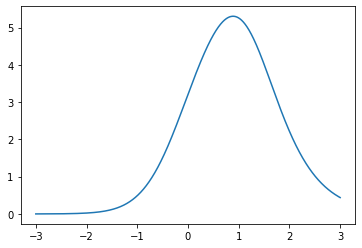

In [19]:
theta = np.linspace(-3,3,1001)
p = c + (1-c) * inv_logit(alpha * np.subtract.outer(theta, beta))
q = 1 - p
info = alpha**2 * (q / p) * np.square((p - c) / (1 - c))
plt.plot(theta, info[:,selected].sum(axis=1))

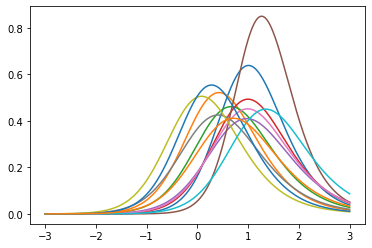

In [20]:
plt.plot(theta, info[:,selected])

<AxesSubplot:ylabel='count'>

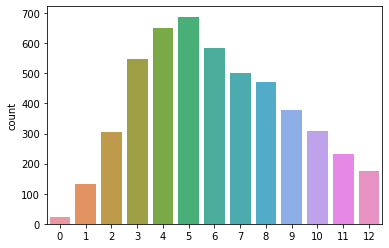

In [17]:
theta = np.random.normal(0,1,5000)
alpha_s = alpha[selected]
beta_s = beta[selected]

p = c + (1-c) * inv_logit(alpha_s * np.subtract.outer(theta, beta_s))
y = np.random.binomial(1, p).sum(axis=1)
sns.countplot(x=y, order=np.arange(13))

(5000, 12)